#  Can we make a hit movie ?
This project aims to understand the descriptions of top n movies and create our very own movie. We also explore different methods of predicting if a movie will stink or be a hit in the box office by using various parameters. So basically,
1. Predict if a movie will be a hit based on Budget, Genre etc. 
2. Make our very own movie.
3. Compare our made-up movie and test it.

So, Let's begin shall we ?

## Step 1: Find our data

*We obtained our dataset from https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings.csv*

lets import it and view what data it contains

*The first cell contains all the imports you'll need for this project. Make sure you run this first*

In [112]:
import pandas as pd 
import numpy as np 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import ast
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


In [113]:
df1=pd.read_csv('./movies_metadata.csv')
df1.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


Our data looks usable, now we need to perform a little cleanup to keep only the data that is relevant to us

So, that brings us to -

## Step 2: Feature Cleaning

Let us drop all the fields that we will not require. Like the IMDB links, Status, Tagline. These features in no way relate to our final output. We can use our common sense to eliminate them.

Some of them, we are not too sure. Take the "runtime" column. A higher runtime may mean a lesser rating. Maybe or Maybe not. But, we cannot eliminate by just using common sense.


In [114]:
# Drop all unneccesary fields
df1.drop(["id","belongs_to_collection","homepage","imdb_id","revenue","spoken_languages","status","tagline","original_title","video","popularity","poster_path","production_companies","production_countries"],axis=1,inplace=True)
# Drop all NULL,None,NA values
df1.dropna()
# Drop all the values where vote average is 0
df1 = df1.replace(0, np.nan).dropna(axis=0, how='any', subset=["vote_count","overview"])
df1

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...
45459,False,0,"[{'id': 878, 'name': 'Science Fiction'}]",en,It's the year 3000 AD. The world's most danger...,1995-01-01,85.0,Caged Heat 3000,3.5,1.0
45460,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,"Yet another version of the classic epic, with ...",1991-05-13,104.0,Robin Hood,5.7,26.0
45461,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",fa,Rising and falling between a man and woman.,NaN,90.0,Subdue,4.0,1.0
45462,False,0,"[{'id': 18, 'name': 'Drama'}]",tl,An artist struggles to finish his work while a...,2011-11-17,360.0,Century of Birthing,9.0,3.0


Our data looks clean enough. However, we cannot use some of the features as is. We need to manipulate this into a more usable form. This is called as Feature Engineering

## Step 3: Feature Engineering

Let us take a look at vote_average and vote_count. One user rating a movie very highly versus 100 users voting a movie very highly has a huge difference, so we need to apply a formula to even this out.

First, let us visualise the data and see for ourselves

<Axes: xlabel='vote_average'>

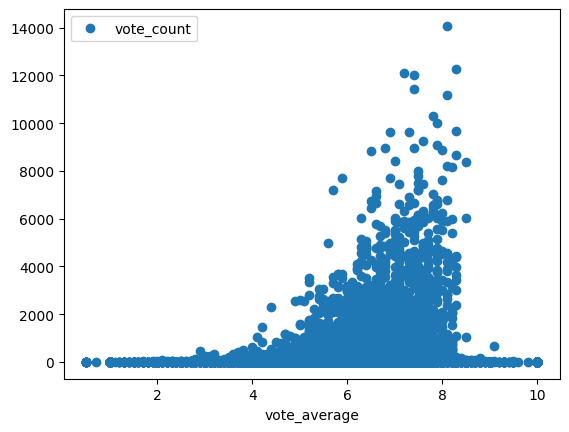

In [115]:
df1.plot(x='vote_average', y='vote_count', style='o')

We can see a lot of votes are being cast by less amount of people. That is why we need a cutoff of the amount of votes and then calculate a weighted average.

Let us set a threshold value "t". We have chosen 1000 votes


(1121, 10)

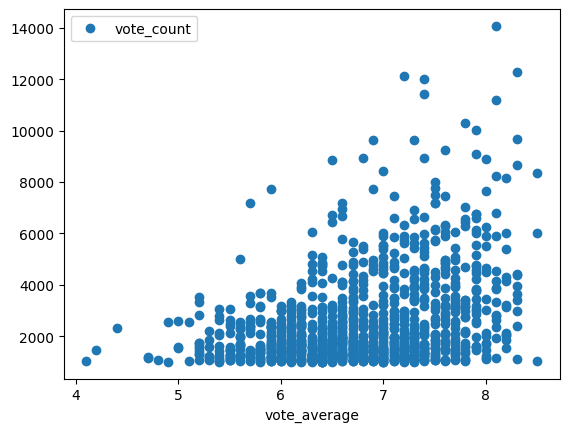

In [116]:
t = 1000
C= df1['vote_average'].mean()
movies = df1.copy().loc[df1['vote_count'] >= t]
movies.plot(x='vote_average', y='vote_count', style='o')
movies.shape

This Looks much better. Now let us calculate our weighted score

*We got this lovely formula from here: https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system*

In [117]:

def weighted_rating(x, t=t, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+t) * R) + (t/(t+v) * C)

movies['score'] = movies.apply(weighted_rating, axis=1)
movies.head(10)



,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,7.7,5415.0,7.437627
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,6.9,2413.0,6.641248
5,False,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,"Obsessive master thief, Neil McCauley leads a ...",1995-12-15,170.0,Heat,7.7,1886.0,7.116798
9,False,58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,James Bond must unmask the mysterious head of ...,1995-11-16,130.0,GoldenEye,6.6,1194.0,6.334220
15,False,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,The life of the gambling paradise – Las Vegas ...,1995-11-22,178.0,Casino,7.8,1343.0,7.038958
18,False,30000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",en,"Summoned from an ashram in Tibet, Ace finds hi...",1995-11-10,90.0,Ace Ventura: When Nature Calls,6.1,1128.0,6.060939
31,False,29500000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"In the year 2035, convict James Cole reluctant...",1995-12-29,129.0,Twelve Monkeys,7.4,2470.0,7.001406
46,False,33000000,"[{'id': 80, 'name': 'Crime'}, {'id': 9648, 'na...",en,Two homicide detectives are on a desperate hun...,1995-09-22,127.0,Se7en,8.1,5915.0,7.798753
47,False,55000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",en,History comes gloriously to life in Disney's e...,1995-06-14,81.0,Pocahontas,6.7,1509.0,6.427732
49,False,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,"Held in an L.A. interrogation room, Verbal Kin...",1995-07-19,106.0,The Usual Suspects,8.1,3334.0,7.619354


This looks much better. Now let us sort it and obtain the top `top` number of movies.

In [118]:
top = 300
movies = movies.sort_values('score', ascending=False)
flop_movies = movies.sort_values('score', ascending=True).head(top)
top_movies = movies.head(top)
top_movies.head(5)

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653
834,False,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",en,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,175.0,The Godfather,8.5,6024.0,8.146480
12481,False,185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,Batman raises the stakes in his war on crime. ...,2008-07-16,152.0,The Dark Knight,8.3,12269.0,8.127936
2843,False,63000000,"[{'id': 18, 'name': 'Drama'}]",en,A ticking-time-bomb insomniac and a slippery s...,1999-10-15,139.0,Fight Club,8.3,9678.0,8.086185
292,False,8000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",en,"A burger-loving hit man, his philosophical par...",1994-09-10,154.0,Pulp Fiction,8.3,8670.0,8.063896


Shawshank Redemption is at first place. Seems like the formula worked afterall. 

What. A. Masterpiece.

Now, let us write some code to cleanup the "Genre" section

In [119]:
def splitGenres(x):
    biglist = []
    x = ast.literal_eval(x)
    for elem in x:
        biglist.append(elem["name"])
    return biglist
movies["genres"] = movies["genres"].apply(splitGenres)
top_movies["genres"] = top_movies["genres"].apply(splitGenres)
movies.head(1)

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,"[Drama, Crime]",en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653


In [120]:
g_movies = movies.explode("genres")
g_movies.head(3)

,adult,budget,genres,original_language,overview,release_date,runtime,title,vote_average,vote_count,score
314,False,25000000,Drama,en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653
314,False,25000000,Crime,en,Framed in the 1940s for the double murder of h...,1994-09-23,142.0,The Shawshank Redemption,8.5,8358.0,8.234653
834,False,6000000,Drama,en,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,175.0,The Godfather,8.5,6024.0,8.146480


<Axes: xlabel='genres'>

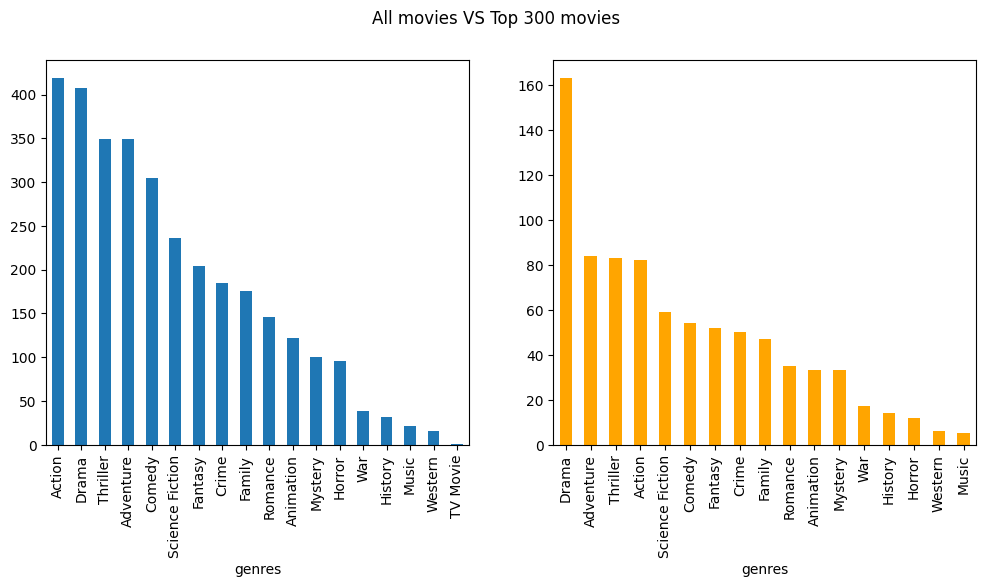

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('All movies VS Top ' + str(top) + ' movies')

top_movies = top_movies.explode("genres")

g_movies.genres.value_counts().plot(kind='bar', ax=axs[0])
top_movies.genres.value_counts().plot(kind='bar',ax=axs[1], color = "orange")

We can clearly see that, although more Action movies have been made; it seems that Drama movies are more popular. 


# Making our movie

The idea is to extract all the descriptions of the top N movies. And then to use this to train our model. 

What exactly can we use ?

the answer is: 
## L.S.T.M (Long Short-Term Memory)

It is a RNN that we can use for sequence prediction. This is akin to your phone predicting what word comes next when you type a word.

An LSTM predicts what word comes next based on context. the input value, previous output and the internal state are all used in a node to give an output as well to update the state information.

First we get all the descriptions and tokenize it. We then pad the input sequence to get n-grams. Finally, we run the LSTM for 30 epochs.

It is very important that we do not overfit the model



In [122]:
#You may encounter a longpath problem here. Make sure
all_descriptions = list(movies.overview.values)
descriptions = [x for x in all_descriptions]
descriptions_top = descriptions[0:300]
descriptions_flop = [x for x in list(flop_movies.overview.values)]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions_top)
total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels
input_sequences = []
for line in descriptions_top:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = np.eye(total_words)[y]

# Build the LSTM model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_length-1))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=30, verbose=1)

## And ... Ta da !

In [124]:
def generate_text(seed_text, next_words, model, max_sequence_length, tokenizer):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generate a story
print(generate_text("Once Upon a time", 80, model, max_sequence_length, tokenizer))
print()
print(generate_text("The", 80, model, max_sequence_length, tokenizer))
print()
print(print(generate_text("", 80, model, max_sequence_length, tokenizer)))

Once Upon a time international scrapes by maui reaches the impetuous chieftain's daughter's island when the cellblock's civil war overtaking 1999 sierra leone these men join on a patient of the unlikely and though he can stop the survivors that brutalized the jedi knight comes to find him into the government to the third nightmare but set as they join a young trio of l d kid who was stop the survivors for her men despite him after a high threat emerges of a

The true story of the gambling paradise – las vegas – and a young white sense of humor deadpool hunts down his life but he is not to be able to recover the world of his comfort zone of traditional arrangements and the villainous bane the entire man who is peace to be responsible for unleashing the most lies of the 20th century from the universe who is peace and also responsible for unleashing the most important lesson of his son

 five years later after inheriting a mysterious job in his old body who is part of his life but he find

Aaaaaaaand its not bad, it does not make much sense. But it has some kind of meaning to it that we can infer.

### Now we do the same for the flop movies

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(descriptions_flop)
total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels
input_sequences = []
for line in descriptions_flop:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = np.eye(total_words)[y]

# Build the LSTM model
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_sequence_length-1))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, y, epochs=30, verbose=1)

In [128]:
def generate_text(seed_text, next_words, model, max_sequence_length, tokenizer):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = np.argmax(predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generate a story
print(generate_text("Once Upon a time", 80, model, max_sequence_length, tokenizer))
print()
print(generate_text("The", 80, model, max_sequence_length, tokenizer))
print()
print(print(generate_text("", 80, model, max_sequence_length, tokenizer)))

Once Upon a time capsule that has just graduated from college and disillusioned at the previous actions of jim's grandmother is sick of becoming wolverine but when he switches tap dance something fierce still a resourceful company employee realizing that the king of the bay controlled by chancellor cohaagen the secrets of the world's most underworld as the doomed prometheus expedition of prophecy to help to be a way they encounter only he's know out to bring them undercover to thwart the evil plans

The story of steve jobs' ascension from college dropout into a beautiful princess which has have a perfect stand to keep kip alive before they encounter faster are it's the fabled fiery 'ghost rider' yet a surprising secret that no sea creature would guess from the treacherous overlord but he is forced to survive the last of the city but when they sleep or would make their way to reclaim the ultimate sacrifice is a nasty creature that hates himself on

 witwicky is a 'mechanic' an elite ass

These output seems very interesting. Our language model is not that powerful, let us a more powerful model to make these descriptions more coherent.
Let us then see what the public likes.
With a little bit of magic we have our output like this:

`Once upon a time, Maui, navigating international conflicts, arrives at the island of the impetuous chieftain's daughter during the civil war in the cellblocks of 1999 Sierra Leone. These men unite in pursuit of an unlikely patient, aiming to halt the survivors that brutalized a Jedi Knight. As the Jedi Knight seeks refuge within the government amid the third nightmare, a young trio of determined kids joins forces to stop the survivors and protect their people, even as a high threat looms on the horizon`

Pretty good right ?

Lets see what the public thinks: https://forms.gle/jzssTGN3k22HWhS37
